In [80]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.signal import place_poles

np.set_printoptions(precision=3, suppress=True)

# Problem 1
---

$
\begin{cases}
    J \ddot{\theta}_1 = -T_c r + K_m i_1 \\
    J \ddot{\theta}_2 = -T_c r + K_m i_2 \\
    T_c = k (x_2 - x_1) + b (\dot{x}_2 - \dot{x}_1) \\
    x_3 = \frac{x_1 + x_2}{2}
\end{cases}
$

where $x_i = \theta_i r$, and $u_i = i_i$

### 1. **State space linear form**

Let the state $\mathbf{x} = \begin{bmatrix} x_1 & x_2 & \dot{x}_1 & \dot{x}_2 \end{bmatrix}^T$, and $\mathbf{y} = \begin{bmatrix} x_3 & T_c \end{bmatrix}^T$. Substituting $T_c$, $\theta_i = x_i / r$, and $u_i = i_i$ to initial first and second equation we get

$
\begin{cases}
    \ddot{x}_1 = \frac{k r^2}{J} (x_1 - x_2) + \frac{b r^2}{J} (\dot{x}_1 - \dot{x}_2) + \frac{K_m r}{J} u_1 \\
    \ddot{x}_2 = \frac{k r^2}{J} (x_1 - x_2) + \frac{b r^2}{J} (\dot{x}_1 - \dot{x}_2) + \frac{K_m r}{J} u_2
\end{cases}
$

Thus,

$
\begin{cases}
    \begin{bmatrix} 
        \dot{x}_1 \\ \dot{x}_2 \\ \ddot{x}_1 \\ \ddot{x}_2
    \end{bmatrix} = 
    \begin{bmatrix}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
        \frac{k r^2}{J} & -\frac{k r^2}{J} & \frac{b r^2}{J} & -\frac{b r^2}{J} \\
        \frac{k r^2}{J} & -\frac{k r^2}{J} & \frac{b r^2}{J} & -\frac{b r^2}{J} \\
    \end{bmatrix}
    \begin{bmatrix} 
        x_1 \\ x_2 \\ \dot{x}_1 \\ \dot{x}_2 
    \end{bmatrix} +
    \begin{bmatrix}
        0 & 0 \\
        0 & 0 \\
        \frac{K_m r}{J} & 0 \\
        0 & \frac{K_m r}{J} \\
    \end{bmatrix}
    \begin{bmatrix}
        u_1 \\ u_2
    \end{bmatrix} \\
    \begin{bmatrix} 
        x_3 \\ T_c
    \end{bmatrix} = 
    \begin{bmatrix}
        0.5 & 0.5 & 0 & 0 \\
        -k & k & -b & b \\
    \end{bmatrix}
    \begin{bmatrix} 
        x_1 \\ x_2 \\ \dot{x}_1 \\ \dot{x}_2 
    \end{bmatrix}
\end{cases}
$

Therefore, 
$
A = 
\begin{bmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    \frac{k r^2}{J} & -\frac{k r^2}{J} & \frac{b r^2}{J} & -\frac{b r^2}{J} \\
    \frac{k r^2}{J} & -\frac{k r^2}{J} & \frac{b r^2}{J} & -\frac{b r^2}{J} \\
\end{bmatrix}$, 
$
B =
\begin{bmatrix}
    0 & 0 \\
    0 & 0 \\
    \frac{K_m r}{J} & 0 \\
    0 & \frac{K_m r}{J} \\
\end{bmatrix}
$,
$
C =
\begin{bmatrix}
    0.5 & 0.5 & 0 & 0 \\
    -k & k & -b & b \\
\end{bmatrix}
$, and $D = \mathbf{0}$

### 2. Stability and controllability 

In [21]:
J = 6.375e-3 * 1e+6  # kg * mm^2
K_m = 5.44e-1 * 1e+3  # N * mm / A
k = 2113 * 1e-3  # N / mm
b = 3.75 * 1e-3  # N * s / mm
r = 5e-2 * 1e+3  # mm

A = np.array(
    [
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [k * r ** 2 / J, -k * r ** 2 / J, b * r ** 2 / J, -b * r ** 2 / J],
        [k * r ** 2 / J, -k * r ** 2 / J, b * r ** 2 / J, -b * r ** 2 / J],
    ]
)
B = np.array(
    [
        [0, 0],
        [0, 0],
        [K_m * r / J, 0],
        [0, K_m * r / J],
    ]
)
C = np.array(
    [
        [0.5, 0.5, 0, 0],
        [-k, k, -b, b],
    ]
)

print(A)
print(B)
print(C)

[[ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.829 -0.829  0.001 -0.001]
 [ 0.829 -0.829  0.001 -0.001]]
[[0.    0.   ]
 [0.    0.   ]
 [4.267 0.   ]
 [0.    4.267]]
[[ 0.5    0.5    0.     0.   ]
 [-2.113  2.113 -0.004  0.004]]


Check eigen values of $A$

In [29]:
for eig_val in np.linalg.eig(A)[0]:
    if np.real(eig_val) > 0:
        print("Unstable!")

Unstable!


$A$ has positive eigen value. Hence, the system is not stable

Check rank $R = \begin{bmatrix} B & AB & A^2 B & A^3 B\end{bmatrix}$

In [41]:
R = np.c_[B, A @ B, A @ A @ B, A @ A @ A @ B]
print(R.shape)

if np.linalg.matrix_rank(R) == 4:
    print("Controllable")
else:
    print("Uncontrollable")

(4, 8)
Controllable


Controllability with only one actuator can be checked with the following $B$:

$
\begin{bmatrix}
    0 \\
    0 \\
    \frac{K_m r}{J} \\
    0
\end{bmatrix}
$

In [42]:
new_B = np.array([[0, 0, K_m * r / J, 0]]).T
R = np.c_[new_B, A @ new_B, A @ A @ new_B, A @ A @ A @ new_B]
print(R.shape)

if np.linalg.matrix_rank(R) == 4:
    print("Controllable")
else:
    print("Uncontrollable")

(4, 4)
Controllable


Due to stabilizability is weaker than controllability we know that one actuator is enough to make the system controllable/stabilizable

### 3. Place poles for closed loop system

$\mathbf{u} = -K [\mathbf{x}-\mathbf{x}_d] + u_d$, therefore, $\dot{\mathbf{x}} - \dot{\mathbf{x}}_d = (A - B K) [\mathbf{x}-\mathbf{x}_d] $. We want that all eigenvalues of $A - B K$ equal some predefined poles.

Therefore we should solve the following system of equations respect to $K$:

$
\begin{cases}
    \text{det}(A - B K - \lambda_1 I) = 0 \\
    \text{det}(A - B K - \lambda_2 I) = 0 \\
    \vdots \\
    \text{det}(A - B K - \lambda_n I) = 0 \\
\end{cases}
$

In [93]:
K = place_poles(A, B, poles=[-1, -2, -3, -4]).gain_matrix
print(K)

[[1.483 0.392 1.172 0.234]
 [0.78  1.095 0.235 1.172]]


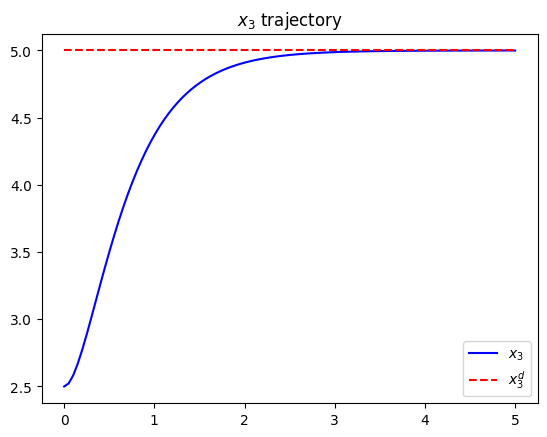

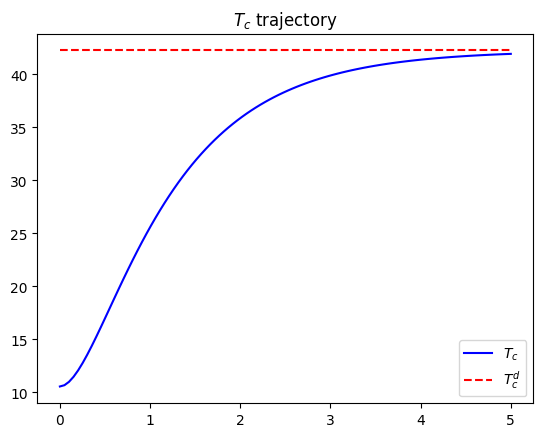

In [94]:
x_1_0 = 0
x_2_0 = 5
x_0 = np.array([x_1_0, x_2_0, 0, 0], dtype=float)
x_1_d = -5
x_2_d = 15
x_d = np.array([x_1_d, x_2_d, 0, 0], dtype=float)
d_x_d = np.zeros(4)

x_3_d = (x_1_d + x_2_d) / 2
t_d = k * (x_2_d - x_1_d)
u_d = np.linalg.pinv(B).dot(d_x_d - A.dot(x_d))


def state_transition_1(x: np.ndarray, _: float) -> np.ndarray:
    return A.dot(x) + B.dot(-K.dot(x - x_d) + u_d)


timespan = np.linspace(0, 5, 100)
sol = odeint(
    state_transition_1, 
    x_0,
    timespan,
)

plt.title("$x_3$ trajectory")
plt.plot(timespan, 0.5 * sol[:, :2].sum(axis=1), color="blue", label="$x_3$")
plt.plot(timespan, x_3_d * np.ones_like(timespan), "--", color="red", label="$x_3^d$")
plt.legend(loc="best")
plt.show()

plt.title("$T_c$ trajectory")
plt.plot(timespan, k * (sol[:, 1] - sol[:, 0]) + b * (sol[:, 3] - sol[:, 2]), color="blue", label="$T_c$")
plt.plot(timespan, t_d * np.ones_like(timespan), "--", color="red", label="$T_c^d$")
plt.legend(loc="best")
plt.show()

# Problem 2

Proposed observer:

$\dot{\hat{\mathbf{x}}} = A\hat{\mathbf{x}} + B \mathbf{u} + L(\mathbf{y} - \hat{\mathbf{y}})$

### Closed loop response for observer

Subtracting from actual response the proposed observer we get 

$\dot{\mathbf{x}} - \dot{\hat{\mathbf{x}}} = A \mathbf{x} - A\hat{\mathbf{x}} - L(\mathbf{y} - \hat{\mathbf{y}})$

Or

$\dot{\mathbf{x}} - \dot{\hat{\mathbf{x}}} = A (\mathbf{x} - \hat{\mathbf{x}}) - LC (\mathbf{x} - \hat{\mathbf{x}})$

Thus, 

$\dot{\mathbf{e}} = (A - LC) \mathbf{e}$

### Convergence conditions

$A - LC$ should be negative-definite, i.e. it should have negative eigenvalues

We can find $L$ via usual pole placement for $A^T - C^T L^T$ or by using LQR

### Implementation

In [121]:
A_ang = A / r
B_ang = B / r
C_ang = C * r

L = place_poles(A_ang.T, C_ang.T, poles=[-5, -6, -7, -8]).gain_matrix.T
K = place_poles(A_ang, B_ang, poles=[-0.1, -0.2, -0.3, -0.4]).gain_matrix
print(L)
print(K)

[[ 0.28  -0.042]
 [ 0.28   0.042]
 [48.    -8.282]
 [48.     8.282]]
[[32.421 14.454  5.86   1.172]
 [14.843 32.032  1.172  5.859]]


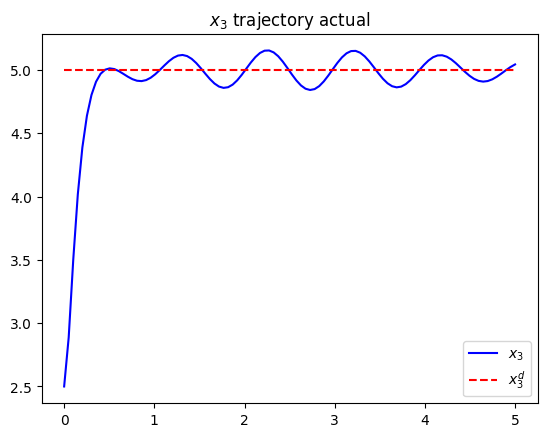

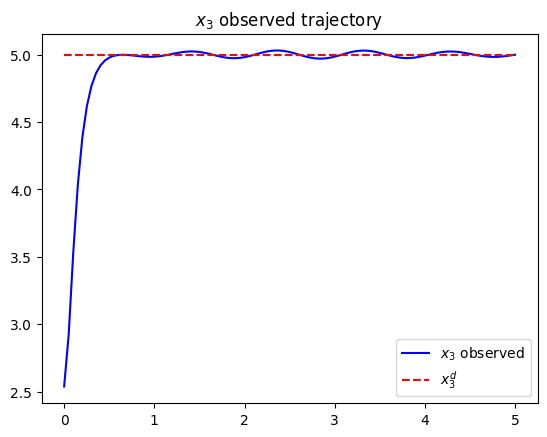

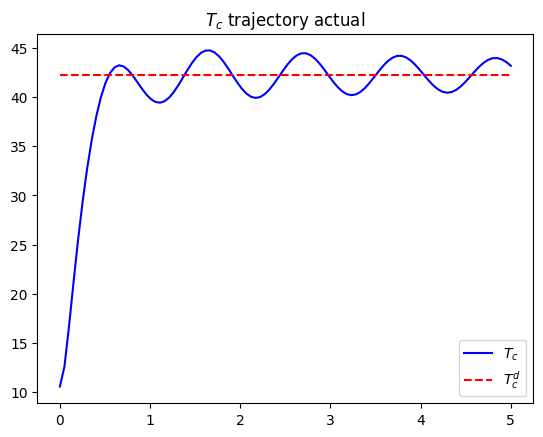

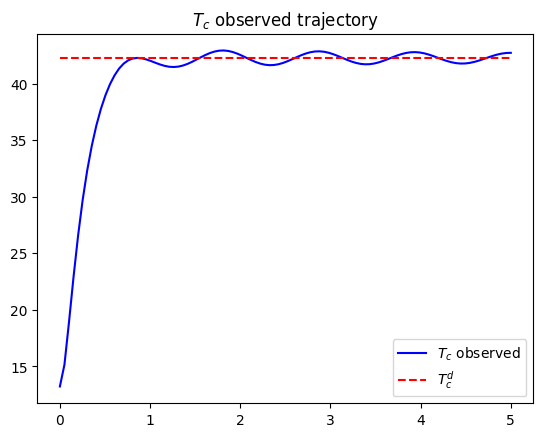

In [123]:
np.random.seed(404)

theta_1_0 = 0 / r
theta_2_0 = 5 / r
theta_0 = np.array([theta_1_0, theta_2_0, 0, 0], dtype=float)
theta_0_obs = theta_0 + np.random.normal(loc=0, scale=0.01, size=4)
theta_1_d = -5 / r
theta_2_d = 15 / r
theta_d = np.array([theta_1_d, theta_2_d, 0, 0], dtype=float)
d_theta_d = np.zeros(4)

x_3_d = (theta_1_d + theta_2_d) * r / 2
t_d = k * (theta_2_d - theta_1_d) * r
u_d = np.linalg.pinv(B_ang).dot(d_theta_d - A_ang.dot(theta_d))

def state_transition_2(x: np.ndarray, _: float) -> np.ndarray:
    x_act = x[:4]
    x_obs = x[4:]
    y = C.dot(x_act)
    u = -K.dot(x_obs - theta_d) + u_d
    return np.r_[
        A.dot(x_act) + B.dot(u),
        A.dot(x_obs) + B.dot(u) + L.dot(y - C.dot(x_obs)),
    ]


timespan = np.linspace(0, 5, 100)
sol = odeint(
    state_transition_2, 
    np.r_[theta_0, theta_0_obs],
    timespan,
)

plt.title("$x_3$ trajectory actual")
plt.plot(timespan, 0.5 * r * sol[:, :2].sum(axis=1), color="blue", label="$x_3$")
plt.plot(timespan, x_3_d * np.ones_like(timespan), "--", color="red", label="$x_3^d$")
plt.legend(loc="best")
plt.show()

plt.title("$x_3$ observed trajectory")
plt.plot(timespan, 0.5 * r * sol[:, 4:6].sum(axis=1), color="blue", label="$x_3$ observed")
plt.plot(timespan, x_3_d * np.ones_like(timespan), "--", color="red", label="$x_3^d$")
plt.legend(loc="best")
plt.show()

plt.title("$T_c$ trajectory actual")
plt.plot(timespan, k * r * (sol[:, 1] - sol[:, 0]) + b * (sol[:, 3] - sol[:, 2]), color="blue", label="$T_c$")
plt.plot(timespan, t_d * np.ones_like(timespan), "--", color="red", label="$T_c^d$")
plt.legend(loc="best")
plt.show()

plt.title("$T_c$ observed trajectory")
plt.plot(timespan, k * r * (sol[:, 5] - sol[:, 4]) + b * (sol[:, 7] - sol[:, 6]), color="blue", label="$T_c$ observed")
plt.plot(timespan, t_d * np.ones_like(timespan), "--", color="red", label="$T_c^d$")
plt.legend(loc="best")
plt.show()